In [1]:
import pickle

results_path = "/home/yuhaojiang/torch_docker/SMPLer-X/cache/2457db3r_20231127_195937/results.pkl"
with open(results_path, 'rb') as file:
    results = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/home/yuhaojiang/torch_docker/SMPLer-X/cache/2457db3r_20231127_195937/results.pkl'

In [ ]:
# import torch
# for item, motions in results.items():
#     for human_id, motion in motions.items():
#         results[item][human_id] = torch.cat(list(motion.values()), dim=0)

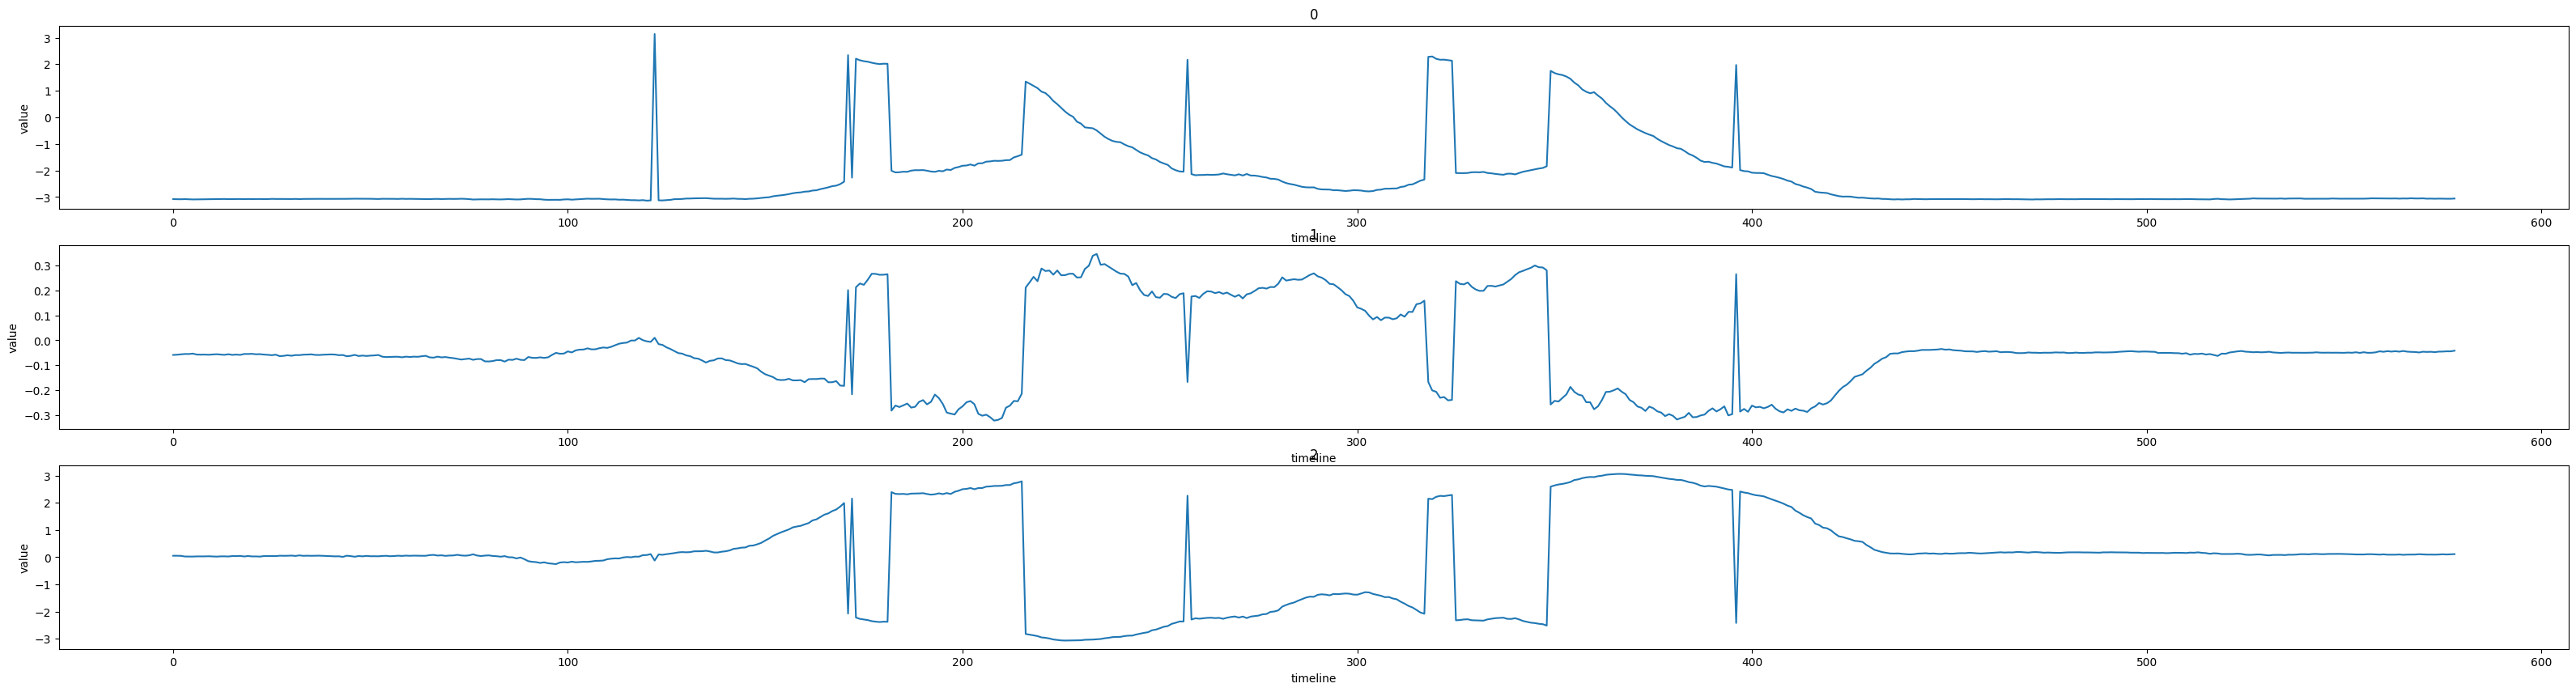

In [ ]:
# import numpy as np
# from matplotlib import pyplot as plt

# curves = results["smplx_root_pose"][0].numpy()
# num_items = curves.shape[-1]
# timeline = np.arange(curves.shape[0])
# fig, axs = plt.subplots(num_items, 1, figsize=(40, 10))
# for idx in range(num_items):
#     plot_data = curves[:, idx]
#     axs[idx].plot(timeline, plot_data.tolist())
#     axs[idx].set_xlabel('timeline')
#     axs[idx].set_ylabel('value')
#     axs[idx].set_title(f"{idx}")
# plt.show()

In [ ]:
from numba import njit

@njit
def axis_continuity(axis):
    last_axis = axis[0]
    for i in range(axis.shape[0]):
        is_right_direction = ((axis[i] - last_axis)**2).sum() < ((-axis[i] - last_axis)**2).sum()
        axis[i] = axis[i] if is_right_direction else -axis[i]
        last_axis = axis[i]
    return axis

EPS = 1e-6
@njit
def unpack_axis_angle(axis_angle):
    angle = np.sqrt((axis_angle**2).sum())
    axis = axis_angle / (angle + EPS)
    return axis, angle

@njit
def angle_continuity(angle, last_angle):
    angle, last_angle = angle / np.pi, last_angle/ np.pi
    diff_angle = (angle - last_angle) %2
    diff_angle = diff_angle if np.abs(diff_angle) < np.abs((2-diff_angle)) else 2-diff_angle
    angle = last_angle + diff_angle
    return angle

@njit  
def axis_angle_continuity(axis_angle):
    last_axis, last_angle = unpack_axis_angle(axis_angle[0])
    for i in range(axis_angle.shape[0]):
        axis, angle = unpack_axis_angle(axis_angle[i])
        is_right_direction = ((axis - last_axis)**2).sum() < ((-axis - last_axis)**2).sum()
        if is_right_direction:
            axis = axis
            angle = angle
        else:
            axis = -axis
            angle = -angle
        angle = angle_continuity(angle, last_angle)
        axis_angle[i] = axis * angle
        last_axis, last_angle = axis, angle
    return axis_angle

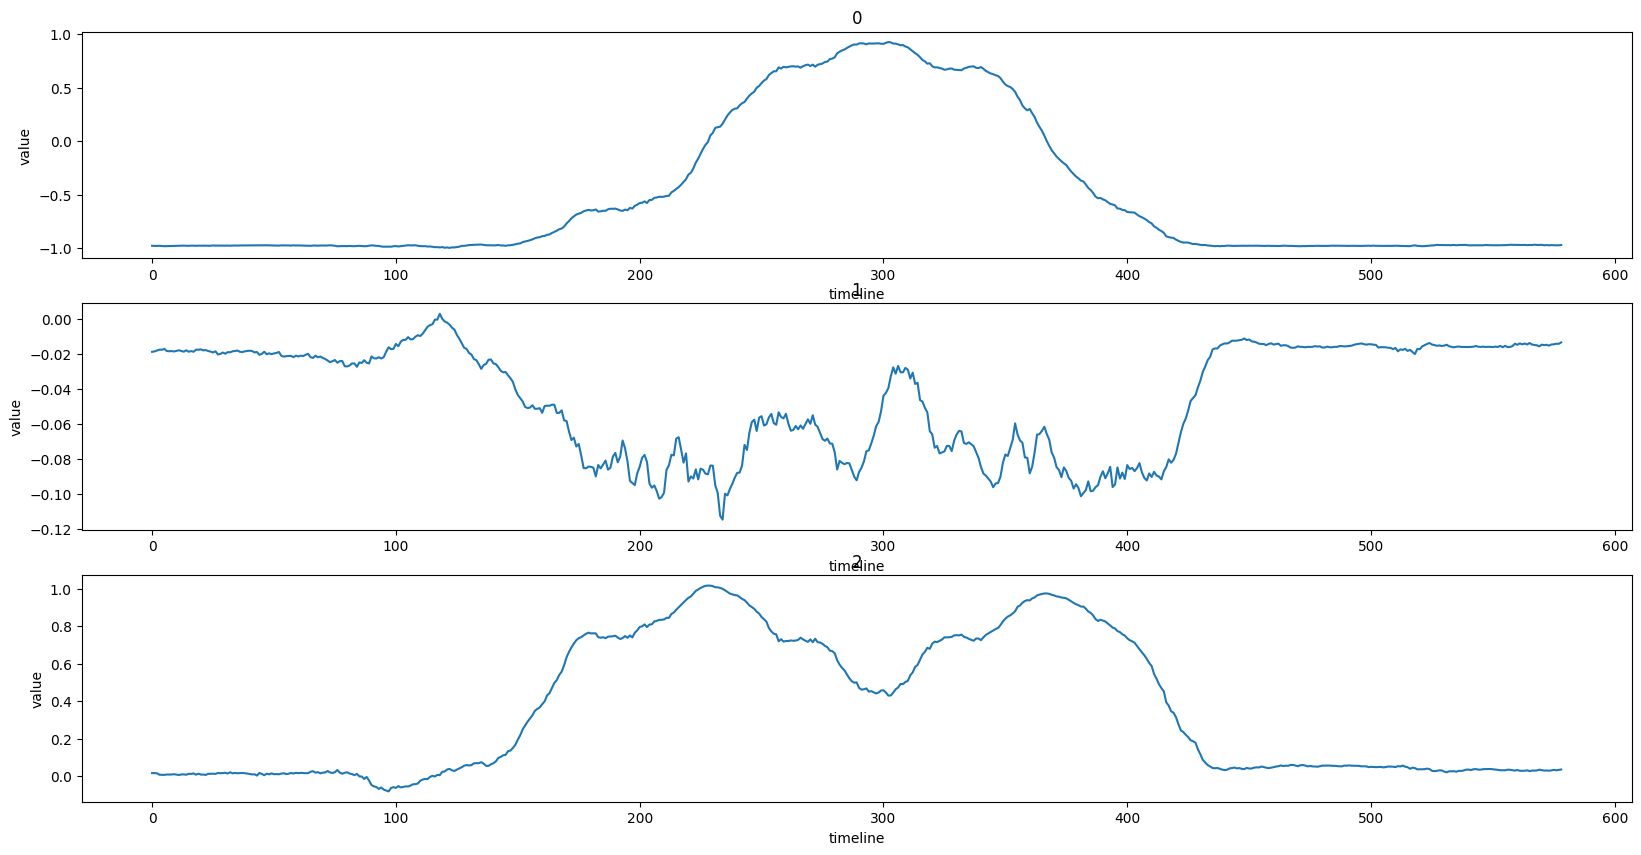

In [ ]:
# curves = axis_angle_continuity(curves)
# num_items = curves.shape[-1]
# timeline = np.arange(curves.shape[0])
# fig, axs = plt.subplots(num_items, 1, figsize=(20, 10))
# for idx in range(num_items):
#     plot_data = curves[:, idx]
#     axs[idx].plot(timeline, plot_data.tolist())
#     axs[idx].set_xlabel('timeline')
#     axs[idx].set_ylabel('value')
#     axs[idx].set_title(f"{idx}")
# plt.show()

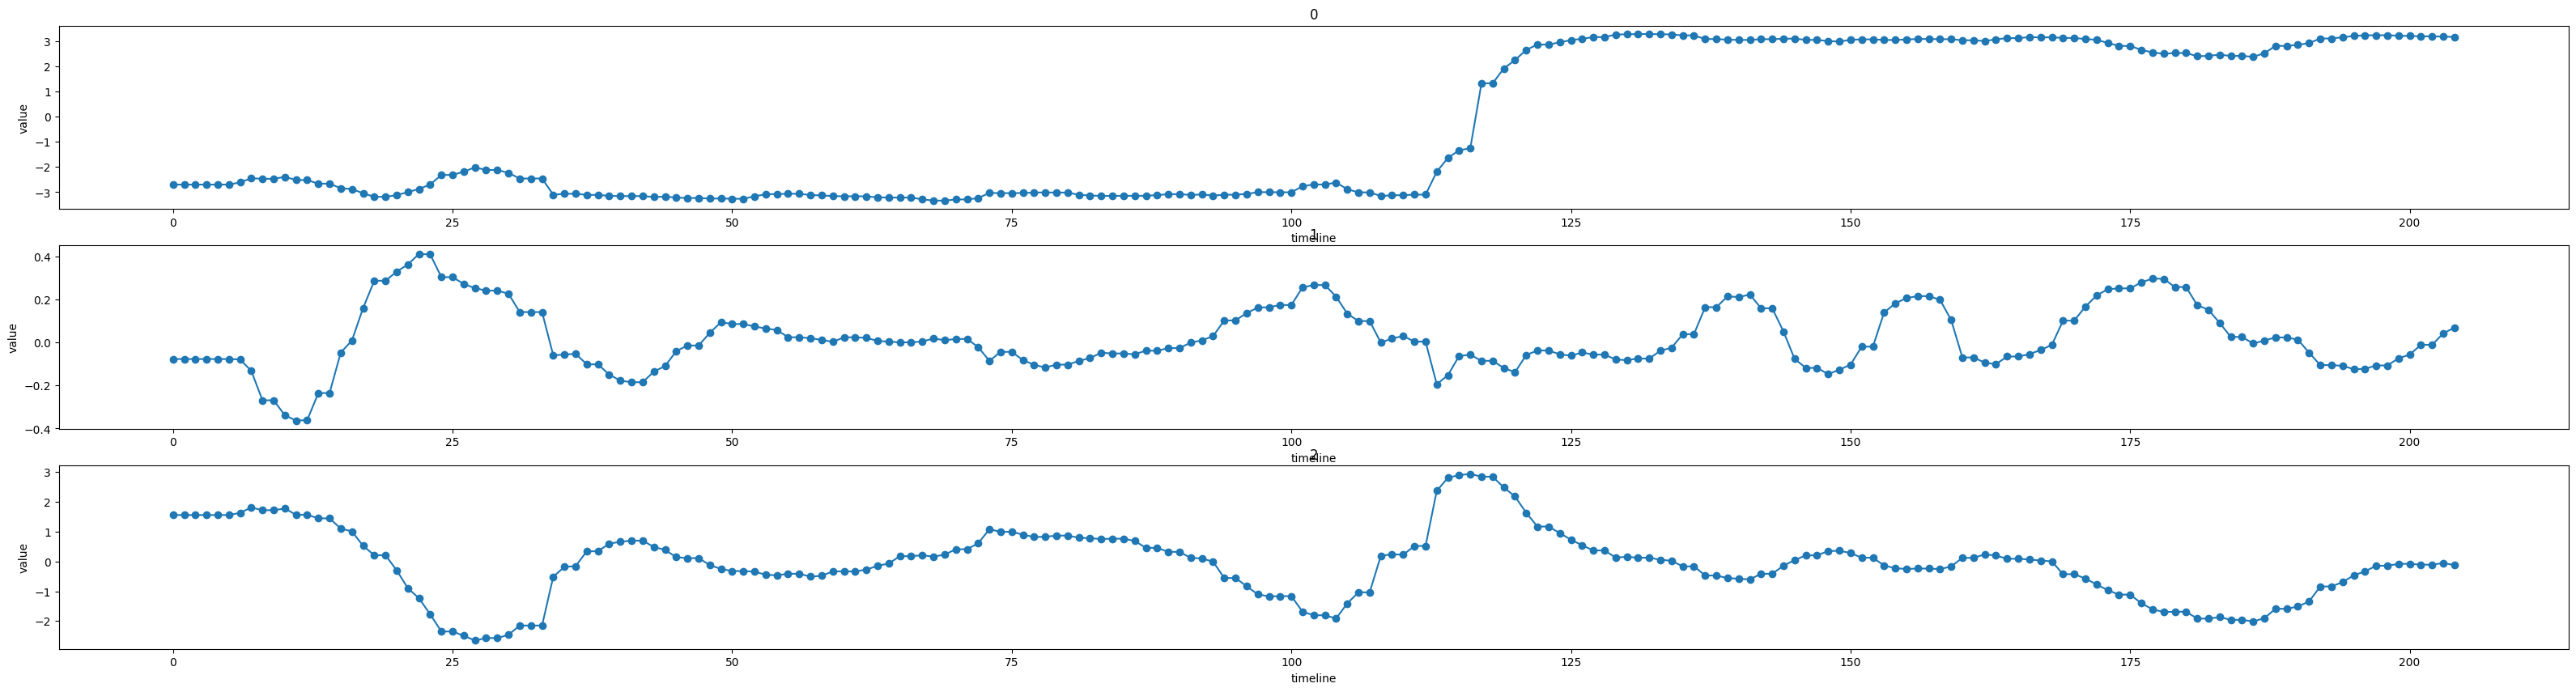

In [63]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import torch

curve_continuity_path = "/home/yuhaojiang/torch_docker/SMPLer-X/cache/curve_continuity.pkl"
with open(curve_continuity_path, 'rb') as file:
    results = pickle.load(file)

curves = results["smplx_root_pose"][0]
curves = torch.cat(list(curves.values())).numpy()
num_items = curves.shape[-1]
timeline = np.arange(curves.shape[0])
fig, axs = plt.subplots(num_items, 1, figsize=(40, 10))
for idx in range(num_items):
    plot_data = curves[:, idx]
    axs[idx].plot(timeline, plot_data.tolist(), "o-")
    axs[idx].set_xlabel('timeline')
    axs[idx].set_ylabel('value')
    axs[idx].set_title(f"{idx}")
plt.show()

In [64]:
from pytorch3d.transforms import axis_angle_to_quaternion

quat = axis_angle_to_quaternion(
    torch.from_numpy(curves),
)

from fbx import FbxQuaternion

euler = []
for i in range(curves.shape[0]):
    w, x, y, z = quat[i]
    fbxEuler = FbxQuaternion(w, x, y, z).DecomposeSphericalXYZ()
    X, Y, Z = fbxEuler[0], fbxEuler[1], fbxEuler[2]
    euler.append([X, Y, Z])

In [65]:
def curve_continuity(curve):
    last_curve = curve[0]
    for i in range(1, curve.shape[0]):
        diff = curve[i] - last_curve
        diff = min([diff, diff - 360, diff + 360], key=lambda x: torch.abs(x))
        curve[i] = last_curve + diff
    return curve

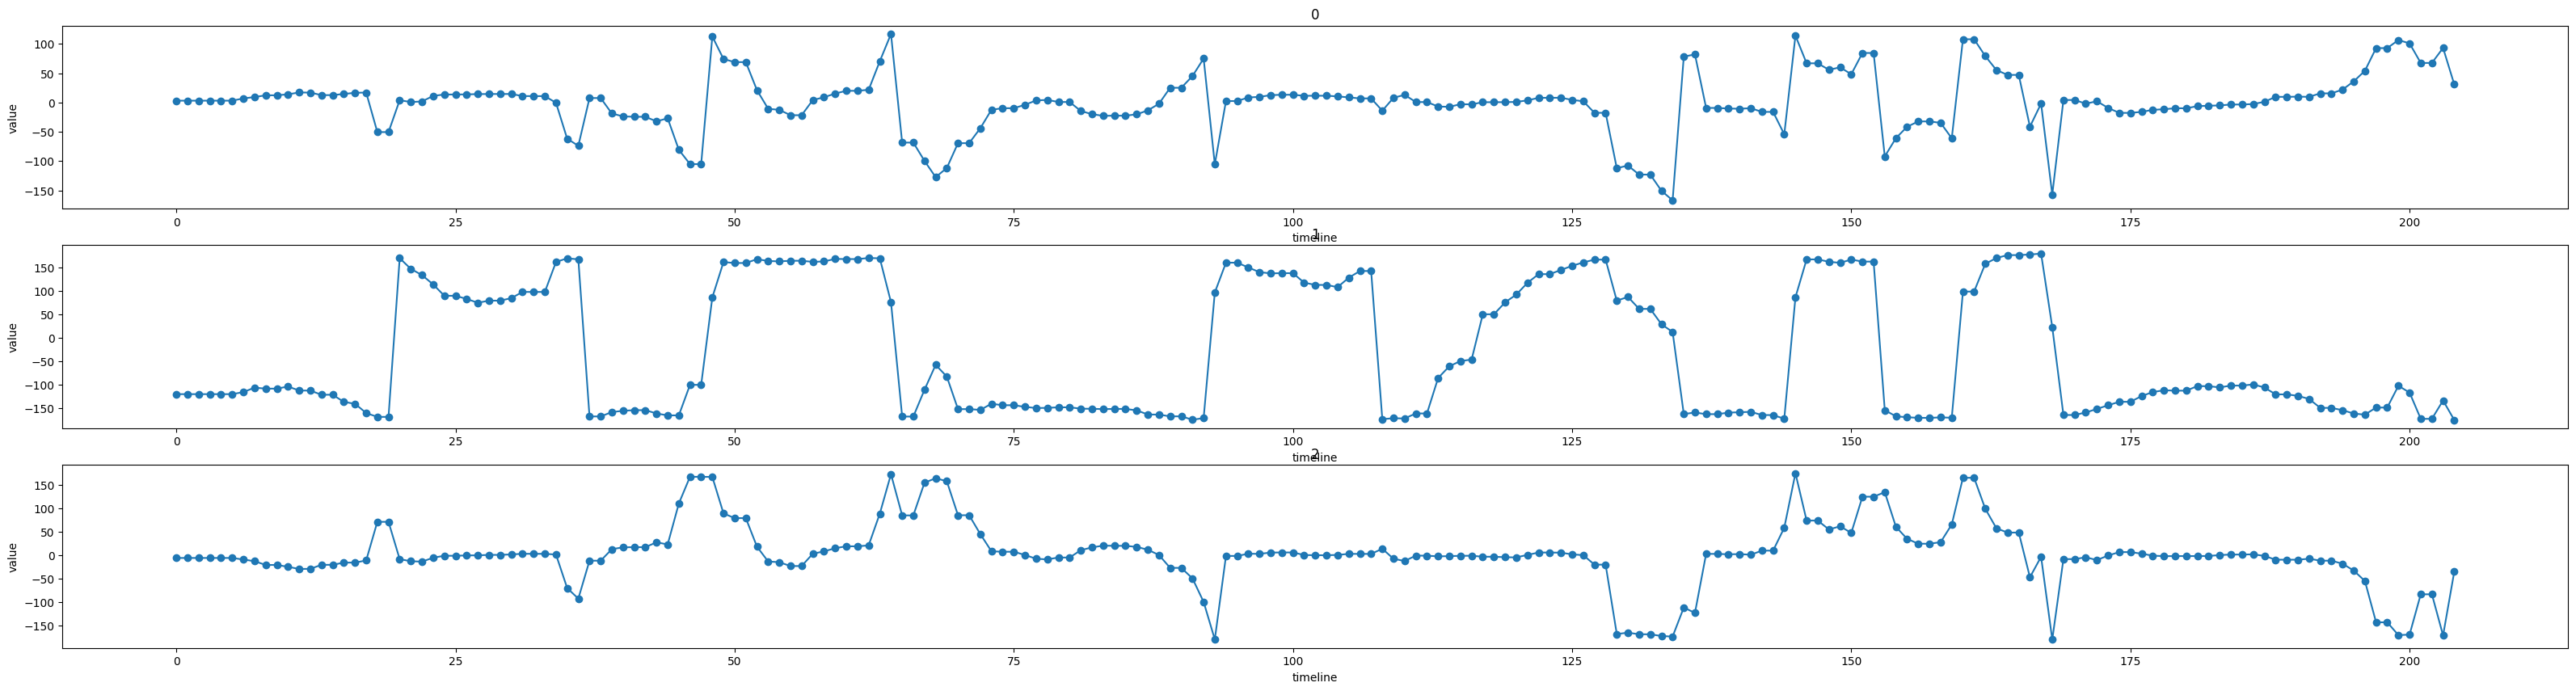

In [66]:
curves = torch.tensor(euler)
num_items = curves.shape[-1]
timeline = np.arange(curves.shape[0])
fig, axs = plt.subplots(num_items, 1, figsize=(40, 10))
for idx in range(num_items):
    plot_data = curves[:, idx]
    axs[idx].plot(timeline, plot_data.tolist(), "o-")
    axs[idx].set_xlabel('timeline')
    axs[idx].set_ylabel('value')
    axs[idx].set_title(f"{idx}")
plt.show()

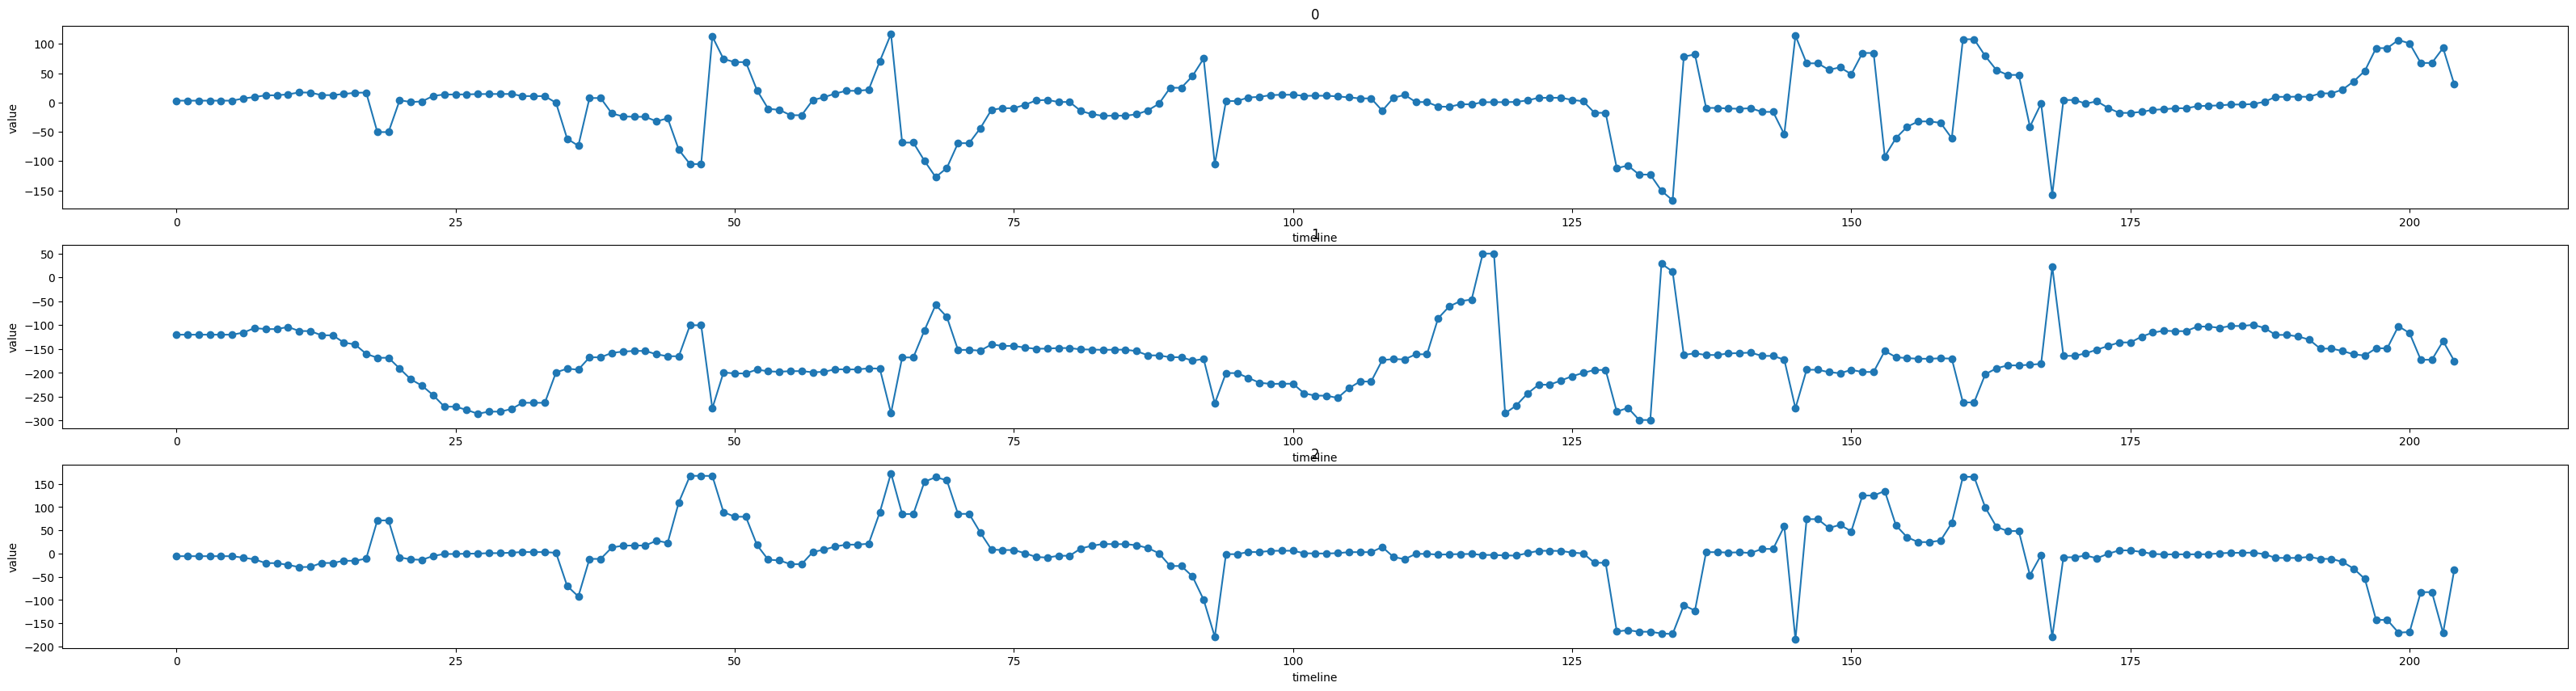

In [67]:
curves = torch.tensor(euler)
num_items = curves.shape[-1]
timeline = np.arange(curves.shape[0])
fig, axs = plt.subplots(num_items, 1, figsize=(40, 10))
for idx in range(num_items):
    plot_data = curve_continuity(curves[:, idx])
    axs[idx].plot(timeline, plot_data.tolist(), "o-")
    axs[idx].set_xlabel('timeline')
    axs[idx].set_ylabel('value')
    axs[idx].set_title(f"{idx}")
plt.show()